In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.transforms.Resize(size=256),
    torchvision.transforms.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.transforms.ToTensor(),
    torchvision.transforms.transforms.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), 
                                                 std=torch.Tensor([0.2290, 0.2240, 0.2250])),
])

# the json file where the output must be stored
json_file = open("imagenet_labels.json", "r")
imagenet_dict = json.load(json_file)
json_file.close()

def predict(model, img):
    output = model(img)
    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
    return top5_probabilities, top5_class_indices.tolist()[0]

def preprocess_data(img):
    # unsqueeze single image into batch of 1.
    return transforms(img).unsqueeze(0)

def idx_to_label(idx):
    if isinstance(idx, list):
        return [idx_to_label(i) for i in idx]
    else:
        return imagenet_dict.get(str(idx))

In [2]:
model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
from energy_meter import EnergyMeter
import time

# If we run this twice, the GPU seems to be preprocessing the image when
# we run the CPU test. In order to avoid it, it's necessary to load the
# model again, so it seems something remains in the GPU even after running
# model.to("cpu").

img = Image.open(urlopen(
    'https://unsplash.com/photos/DwxlhTvC16Q/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8bWVyY2VkZXMlMjBjYXJ8ZW58MHx8fHwxNjg2NzA1MzUyfDA&force=true&w=640'
))

# CPU
# Disk in LSD15 has an avg i/o speed of 1600MB/s and 
# a power consumption of 6W when active and 1.42W when idle.
meter_cpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="CPU Inference")
model = model.to("cpu")

meter_cpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cpu")
    probs, labels = predict(model, p_img)
meter_cpu.end()

# To ensure samples from GPU power stats are not mixed up.
time.sleep(1)

meter_gpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="GPU Inference")
model = model.to("cuda:0")
meter_gpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cuda:0")
    probs, labels = predict(model, p_img)
meter_gpu.end()

 You need to install pymongo>=3.9.0 in order to use MongoOutput 


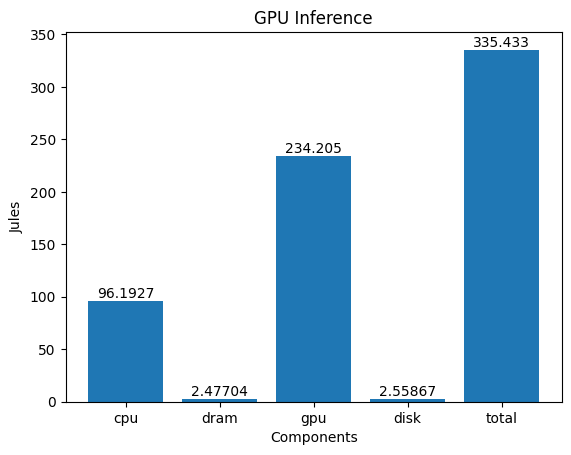

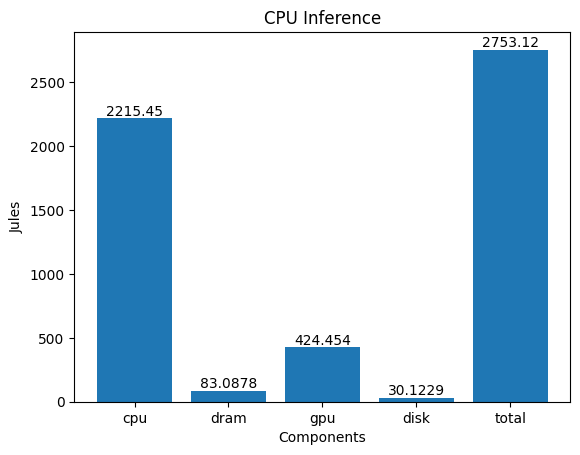

In [4]:
import energy_meter
from importlib import reload
reload(energy_meter)

meter_gpu.plot_total_jules_per_component()
meter_cpu.plot_total_jules_per_component()